### Initialization

##### Installation

In [7]:
%pip install --upgrade pip
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##### Imports

In [8]:
# system imports
import os
import cv2
import uuid
import json
import joblib
import sys
from IPython.display import clear_output
from typing import Any

# utility imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# third-party imports
from rembg import remove

# ML imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

#FileUpload
from ipywidgets import FileUpload
from ipyfilechooser import FileChooser

##### Global vars

In [9]:
uploader = FileUpload(accept='image/*', multiple=False)
display(uploader)

filename = None
extension = None
dir_identifier = None

def on_upload_change(change):
    global filename
    global extension
    global dir_identifier
    if uploader.value:
        upload_info = uploader.value[0]
        filename = upload_info['name']
        content = upload_info['content']

        os.makedirs("assets", exist_ok=True)
        with open(f"assets/{filename}", "wb") as f:
            f.write(content)

        print(f"Arquivo salvo em assets/{filename}")

        if not os.path.exists(f'assets/{filename}'):
            raise FileNotFoundError(f"File '{filename}' does not exist.")

        dir_identifier = uuid.uuid4().hex
        extension = filename.split('.')[-1]
        filename = '.'.join(filename.split('.')[:-1])

        os.makedirs(f'outputs/{dir_identifier}', exist_ok=True)

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

##### Plot function (to compare and save two images)

In [10]:
global show
show = True
def plot_images(
    step: str,
    original: np.ndarray,
    processed: np.ndarray,
    title1: str = 'Original',
    title2: str = 'Processed'
) -> None:
    """
    Plots two images side by side for comparison.

    Args:
        step (str): Step identifier for the image.
        original (np.ndarray): The original image to be displayed.
        processed (np.ndarray): The processed image to be displayed.
        title1 (str, optional): Title for the original image. Defaults to 'Original'.
        title2 (str, optional): Title for the processed image. Defaults to 'Processed'.
    """
    if not show:
        return


    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title(title1)
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.tight_layout()
    
    cv2.imwrite(f'outputs/{dir_identifier}/{filename}-{step}.{extension}', processed)
    plt.savefig(f'outputs/{dir_identifier}/plot-{filename}-{step}.{extension}')
    plt.show()

### Remove background of pH strip

##### Remove background

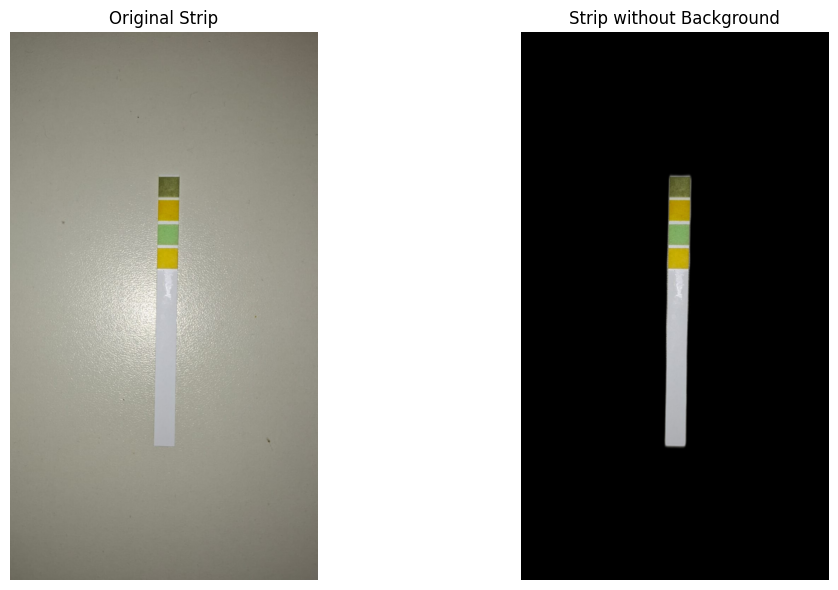

In [11]:
def remove_background(
  strip: np.ndarray,
) -> np.ndarray:
    """
    Removes the background from the strip image using rembg.

    Args:
        strip (np.ndarray): The input image with a background.

    Returns:
        np.ndarray: The image with the background removed.
    """
    strip_without_bg = remove(strip)
    
    plot_images(
        step='1-remove-bg',
        original=strip,
        processed=strip_without_bg,
        title1='Original Strip',
        title2='Strip without Background'
    )
    return strip_without_bg

strip = cv2.imread(f'assets/{filename}.{extension}')
strip_without_bg = remove_background(strip)

### Adjust strip

##### Crop strip

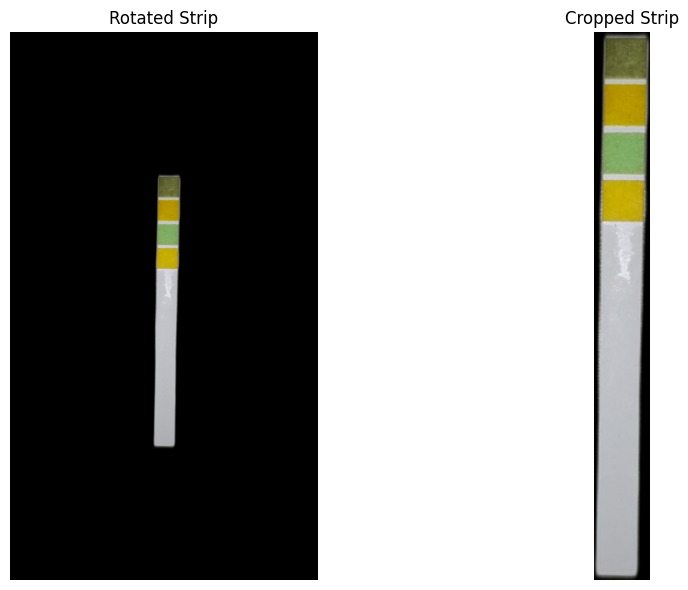

In [12]:
def crop(    
    strip: np.ndarray,
) -> np.ndarray:
    """
    Crops the strip strip to remove any excess background.

    Args:
        strip (np.ndarray): The strip image of the strip.

    Returns:
        np.ndarray: The cropped image of the strip.
    """
    gray_strip = cv2.cvtColor(strip, cv2.COLOR_BGR2GRAY)
    _, binary_strip = cv2.threshold(gray_strip, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_strip, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    cropped = strip[y:y+h, x:x+w]

    plot_images(
        step='3-crop',
        original=strip,
        processed=cropped,
        title1='Rotated Strip',
        title2='Cropped Strip'
    )

    return cropped
  
cropped_strip = crop(strip_without_bg)
cropped_strip = cv2.cvtColor(cropped_strip, cv2.COLOR_BGR2RGB)

### Extract median RGBs

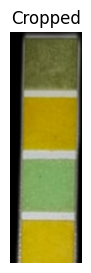

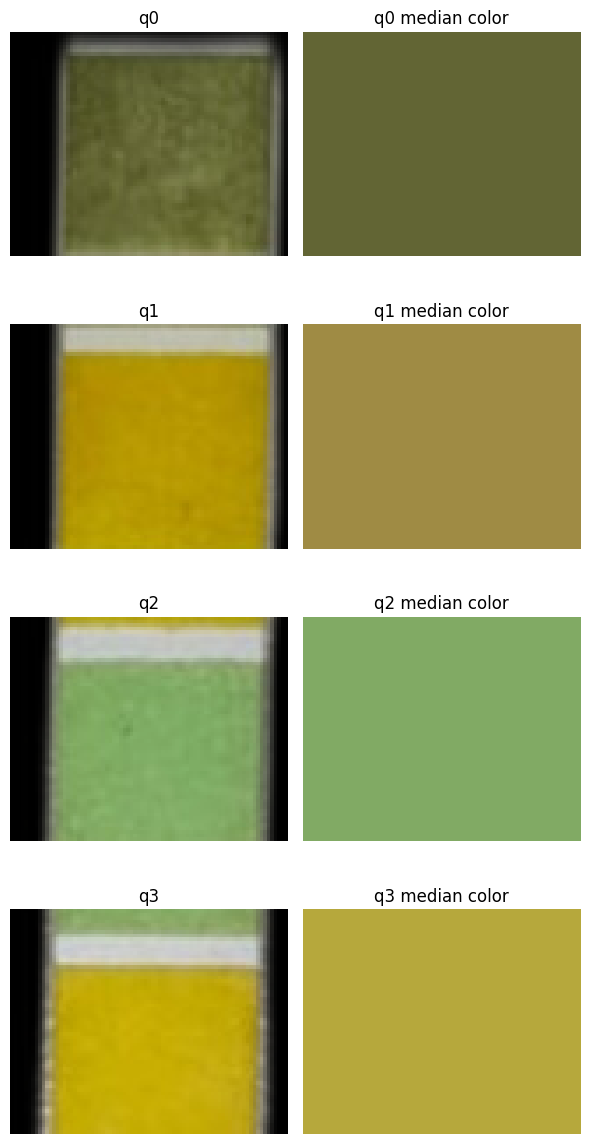

In [13]:
def extract_median_rgbs(strip: np.ndarray) -> [np.ndarray]:
    # Garantir que não tenha canal alfa
    if strip.shape[-1] == 4:
        strip = strip[:, :, :3]

    bottom_half = strip[strip.shape[0] // 2:, :, :]
    upper_half = strip[:strip.shape[0] // 2, :, :]

    # Detecta fundo branco
    mask = (bottom_half >= (50, 50, 50)).all(axis=-1)
    avg_white = np.mean(bottom_half[mask], axis=0)
    std = np.std(bottom_half[mask], axis=0)
    tolerated_distance = 3 * std

    # Encontrar limites do conteúdo colorido
    # Parâmetros
    threshold_dark = 50  # ignora pixels muito escuros
    color_y1 = upper_half.shape[0] - 1
    while color_y1 >= 0:
        row = upper_half[color_y1, :, :]
        # ignora pixels escuros
        mask = (row > threshold_dark).all(axis=1)
        if mask.any():
            median_pixel = np.median(row[mask], axis=0)
            pixel_center = row[row.shape[0] // 2]
            if not (np.abs(pixel_center - median_pixel) <= tolerated_distance).all():
                break
        color_y1 -= 1

    color_y0 = 0
    while color_y0 < upper_half.shape[0]:
        row = upper_half[color_y0, :, :]
        mask = (row > threshold_dark).all(axis=1)
        if mask.any():
            median_pixel = np.median(row[mask], axis=0)
            pixel_center = row[row.shape[0] // 2]
            if (np.abs(pixel_center - median_pixel) <= tolerated_distance).all():
                break
        color_y0 += 1
    color_y0 = max(0, color_y0-1)

    # Recorte
    cropped = upper_half[color_y0:color_y1, :, :]

    # Plotar cropped sozinho
    plt.figure(figsize=(6, 3))
    plt.imshow(cropped)
    plt.title("Cropped")
    plt.axis("off")
    plt.show()

    # Divisão em 4 partes verticais
    q0 = cropped[:cropped.shape[0] // 4, :, :]
    q1 = cropped[cropped.shape[0] // 4:cropped.shape[0] // 2, :, :]
    q2 = cropped[cropped.shape[0] // 2:3 * cropped.shape[0] // 4, :, :]
    q3 = cropped[3 * cropped.shape[0] // 4:, :, :]
    quarters = [q0, q1, q2, q3]
    medians = []
    threshold_dark = 5
    for q in quarters:
        # máscara de pixels que são maiores que threshold em todos os canais
        mask = (q > threshold_dark).all(axis=-1)
        if mask.any():
            # pega só os pixels válidos
            valid_pixels = q[mask]
            median = np.median(valid_pixels, axis=(0))
        else:
            # caso todos os pixels sejam escuros
            median = np.array([0, 0, 0])
        medians.append(median)

    # Mostrar quadrantes e medianas
    fig, axes = plt.subplots(4, 2, figsize=(6, 12))
    for i, (quad, med) in enumerate(zip(quarters, medians)):
        axes[i, 0].imshow(quad)
        axes[i, 0].set_title(f"q{i}")
        axes[i, 0].axis("off")
        median_patch = np.ones_like(quad, dtype=np.uint8) * med.astype(np.uint8)
        axes[i, 1].imshow(median_patch)
        axes[i, 1].set_title(f"q{i} median color")
        axes[i, 1].axis("off")
    plt.tight_layout()
    plt.show()
    return medians

median_rgbs = extract_median_rgbs(cropped_strip)

### Dataset Build

##### Setup

In [4]:
whoami = os.getlogin()
fc = FileChooser('/home/' + whoami + '/Documents')
display(fc)

print(fc.selected_path)

os.makedirs("artifacts", exist_ok=True)

FileChooser(path='/home/vic/Documents', filename='', title='', show_hidden=False, select_desc='Select', change…

None


##### File extractor

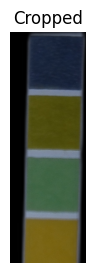

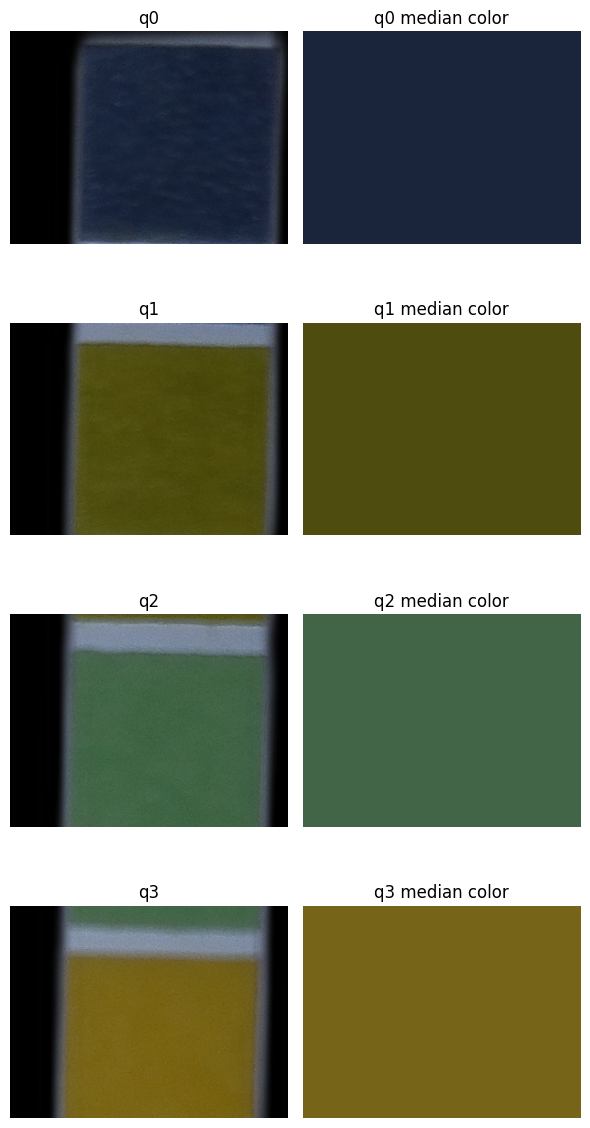

SystemExit: 1

/home/vic/.pyenv/versions/phia-backend/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:


os.makedirs("artifacts", exist_ok=True)

dataset_path = fc.selected_path
labels = os.listdir(dataset_path)

columns = ['label', 'Q0_R', 'Q0_G', 'Q0_B', 'Q1_R', 'Q1_G', 'Q1_B', 
           'Q2_R', 'Q2_G', 'Q2_B', 'Q3_R', 'Q3_G', 'Q3_B', 'strip_id', 'real_ph']

df_dataset = pd.DataFrame(columns=columns)
df_skipped = pd.DataFrame(columns=['strip_id', 'file'])

global show
show = False

for label in labels:
    label_path = os.path.join(dataset_path, label)
    images = os.listdir(label_path)
    for image in images:
        
        strip_id,real_ph = image.split('-')
        real_ph = ('.').join(real_ph.split('.')[:-1])

        image_path = os.path.join(label_path, image)
        strip = cv2.imread(image_path)
        
        strip_without_bg = remove_background(strip)
        # rotated_strip = rotate_vertically(strip_without_bg)
        # cropped_strip = crop(rotated_strip)
        cropped_strip = crop(strip_without_bg)
        cropped_strip = cv2.cvtColor(cropped_strip, cv2.COLOR_BGR2RGB)
        median_rgbs = extract_median_rgbs(cropped_strip)

        user_input = input(f"{image} - pressione Enter para salvar ou digite S para descartar (E para sair): ")
        if user_input.strip().upper() != "S" and user_input.strip().upper() != "E":
            df_dataset.loc[len(df_dataset)] = [label, *[x for tup in median_rgbs for x in tup], strip_id, real_ph]
            df_dataset.to_csv("artifacts/dataset.csv", index=False)
        elif user_input.strip().upper() == "S":
            df_skipped.loc[len(df_skipped)] = [strip_id, image]
            df_skipped.to_csv("artifacts/skipped.csv", index=False)
        elif user_input.strip().upper() == 'E':
            sys.exit(1)

        clear_output(wait=True)

